# Gensim Word2Vec Learning Notebook

* **Reference List**


1. [Gemsim Word2Vec Tutorial](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial)

In [1]:
import numpy
import nltk

In [49]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


In [35]:
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [36]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [44]:
df = df.dropna().reset_index(drop = True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [62]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

In [63]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [64]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [65]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.18 mins


In [67]:
df_clean = pd.DataFrame({'clean':txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(92412, 1)

In [68]:
from gensim.models.phrases import Phrases, Phraser

INFO - 22:05:48: 'pattern' package not found; tag filters are not available for English


In [70]:
sent = [row.split() for row in df_clean['clean']]

In [71]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 22:06:52: collecting all words and their counts
INFO - 22:06:52: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 22:06:52: PROGRESS: at sentence #10000, processed 67396 words and 50551 word types
INFO - 22:06:52: PROGRESS: at sentence #20000, processed 140465 words and 95808 word types
INFO - 22:06:53: PROGRESS: at sentence #30000, processed 207950 words and 132011 word types
INFO - 22:06:53: PROGRESS: at sentence #40000, processed 270207 words and 164407 word types
INFO - 22:06:53: PROGRESS: at sentence #50000, processed 334085 words and 196195 word types
INFO - 22:06:53: PROGRESS: at sentence #60000, processed 400877 words and 228659 word types
INFO - 22:06:53: PROGRESS: at sentence #70000, processed 467802 words and 260712 word types
INFO - 22:06:53: PROGRESS: at sentence #80000, processed 534361 words and 292095 word types
INFO - 22:06:53: PROGRESS: at sentence #90000, processed 602037 words and 321944 word types
INFO - 22:06:53: collected 328658 word typ

In [80]:
bigram = Phraser(phrases)

INFO - 22:11:44: source_vocab length 328658
INFO - 22:11:47: Phraser built with 127 phrasegrams


In [81]:
sentences = bigram[sent]

In [83]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29673

In [85]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['be', 'not', 'oh', 'will', 'like', "'s", 'know', 'think', 'hey', 'good']

## Training the model

### Gensim Word2Vec Implementation:

We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [2]:
import multiprocessing
from gensim.models import Word2Vec

In [88]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [90]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

D:\anaconda\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [91]:
sentences

In [92]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 22:40:30: collecting all words and their counts
INFO - 22:40:30: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 22:40:30: PROGRESS: at sentence #10000, processed 65193 words, keeping 9096 word types
INFO - 22:40:31: PROGRESS: at sentence #20000, processed 136024 words, keeping 13916 word types
INFO - 22:40:31: PROGRESS: at sentence #30000, processed 201577 words, keeping 16865 word types
INFO - 22:40:31: PROGRESS: at sentence #40000, processed 262082 words, keeping 19506 word types
INFO - 22:40:31: PROGRESS: at sentence #50000, processed 324069 words, keeping 21758 word types
INFO - 22:40:32: PROGRESS: at sentence #60000, processed 388895 words, keeping 23910 word types
INFO - 22:40:32: PROGRESS: at sentence #70000, processed 454042 words, keeping 25876 word types
INFO - 22:40:32: PROGRESS: at sentence #80000, processed 518929 words, keeping 27769 word types
INFO - 22:40:32: PROGRESS: at sentence #90000, processed 584755 words, keeping 29345 word types


Time to build vocab: 0.05 mins


In [93]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 22:49:20: training model with 3 workers on 3375 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 22:49:34: EPOCH 1 - PROGRESS: at 1.66% examples, 248 words/s, in_qsize 6, out_qsize 0
INFO - 22:49:45: EPOCH 1 - PROGRESS: at 6.42% examples, 575 words/s, in_qsize 5, out_qsize 0
INFO - 22:49:57: EPOCH 1 - PROGRESS: at 11.55% examples, 698 words/s, in_qsize 5, out_qsize 0
INFO - 22:50:09: EPOCH 1 - PROGRESS: at 16.19% examples, 740 words/s, in_qsize 5, out_qsize 0
INFO - 22:50:21: EPOCH 1 - PROGRESS: at 20.82% examples, 769 words/s, in_qsize 6, out_qsize 0
INFO - 22:50:35: EPOCH 1 - PROGRESS: at 25.38% examples, 777 words/s, in_qsize 5, out_qsize 0
INFO - 22:50:48: EPOCH 1 - PROGRESS: at 30.45% examples, 782 words/s, in_qsize 5, out_qsize 0
INFO - 22:51:02: EPOCH 1 - PROGRESS: at 35.62% examples, 782 words/s, in_qsize 6, out_qsize 0
INFO - 22:51:14: EPOCH 1 - PROGRESS: at 40.98% examples, 793 words/s, in_qsize 5, out_qsize 0
INFO - 22:51:27: EPOCH

INFO - 23:14:28: worker thread finished; awaiting finish of 1 more threads
INFO - 23:14:28: worker thread finished; awaiting finish of 0 more threads
INFO - 23:14:28: EPOCH - 6 : training on 601119 raw words (218947 effective words) took 256.1s, 855 effective words/s
INFO - 23:14:43: EPOCH 7 - PROGRESS: at 1.66% examples, 245 words/s, in_qsize 6, out_qsize 0
INFO - 23:14:56: EPOCH 7 - PROGRESS: at 6.42% examples, 513 words/s, in_qsize 6, out_qsize 0
INFO - 23:14:58: EPOCH 7 - PROGRESS: at 8.21% examples, 620 words/s, in_qsize 6, out_qsize 0
INFO - 23:15:11: EPOCH 7 - PROGRESS: at 11.55% examples, 597 words/s, in_qsize 5, out_qsize 0
INFO - 23:15:13: EPOCH 7 - PROGRESS: at 14.61% examples, 743 words/s, in_qsize 5, out_qsize 0
INFO - 23:15:25: EPOCH 7 - PROGRESS: at 16.19% examples, 638 words/s, in_qsize 5, out_qsize 0
INFO - 23:15:27: EPOCH 7 - PROGRESS: at 19.27% examples, 746 words/s, in_qsize 6, out_qsize 0
INFO - 23:15:40: EPOCH 7 - PROGRESS: at 20.71% examples, 665 words/s, in_qsiz

INFO - 23:40:41: EPOCH 12 - PROGRESS: at 48.28% examples, 739 words/s, in_qsize 5, out_qsize 0
INFO - 23:40:54: EPOCH 12 - PROGRESS: at 51.75% examples, 725 words/s, in_qsize 5, out_qsize 0
INFO - 23:40:56: EPOCH 12 - PROGRESS: at 55.11% examples, 763 words/s, in_qsize 5, out_qsize 0
INFO - 23:41:08: EPOCH 12 - PROGRESS: at 56.77% examples, 728 words/s, in_qsize 6, out_qsize 0
INFO - 23:41:10: EPOCH 12 - PROGRESS: at 60.07% examples, 765 words/s, in_qsize 5, out_qsize 0
INFO - 23:41:23: EPOCH 12 - PROGRESS: at 61.73% examples, 731 words/s, in_qsize 6, out_qsize 0
INFO - 23:41:24: EPOCH 12 - PROGRESS: at 65.09% examples, 764 words/s, in_qsize 5, out_qsize 0
INFO - 23:41:38: EPOCH 12 - PROGRESS: at 66.81% examples, 733 words/s, in_qsize 5, out_qsize 0
INFO - 23:41:52: EPOCH 12 - PROGRESS: at 71.73% examples, 736 words/s, in_qsize 6, out_qsize 0
INFO - 23:41:53: EPOCH 12 - PROGRESS: at 75.05% examples, 766 words/s, in_qsize 5, out_qsize 0
INFO - 23:42:06: EPOCH 12 - PROGRESS: at 76.75% ex

INFO - 00:03:46: EPOCH 17 - PROGRESS: at 32.16% examples, 725 words/s, in_qsize 5, out_qsize 0
INFO - 00:03:59: EPOCH 17 - PROGRESS: at 35.62% examples, 703 words/s, in_qsize 6, out_qsize 0
INFO - 00:04:01: EPOCH 17 - PROGRESS: at 39.12% examples, 759 words/s, in_qsize 5, out_qsize 0
INFO - 00:04:13: EPOCH 17 - PROGRESS: at 40.98% examples, 712 words/s, in_qsize 6, out_qsize 0
INFO - 00:04:14: EPOCH 17 - PROGRESS: at 44.72% examples, 762 words/s, in_qsize 6, out_qsize 0
INFO - 00:04:28: EPOCH 17 - PROGRESS: at 46.58% examples, 716 words/s, in_qsize 5, out_qsize 0
INFO - 00:04:29: EPOCH 17 - PROGRESS: at 48.35% examples, 737 words/s, in_qsize 5, out_qsize 0
INFO - 00:04:42: EPOCH 17 - PROGRESS: at 51.75% examples, 721 words/s, in_qsize 5, out_qsize 0
INFO - 00:04:44: EPOCH 17 - PROGRESS: at 55.11% examples, 761 words/s, in_qsize 5, out_qsize 0
INFO - 00:04:57: EPOCH 17 - PROGRESS: at 56.77% examples, 724 words/s, in_qsize 5, out_qsize 0
INFO - 00:05:11: EPOCH 17 - PROGRESS: at 61.73% ex

INFO - 00:29:47: EPOCH 22 - PROGRESS: at 80.01% examples, 761 words/s, in_qsize 6, out_qsize 0
INFO - 00:30:00: EPOCH 22 - PROGRESS: at 81.64% examples, 735 words/s, in_qsize 6, out_qsize 0
INFO - 00:30:01: EPOCH 22 - PROGRESS: at 84.97% examples, 762 words/s, in_qsize 5, out_qsize 0
INFO - 00:30:14: EPOCH 22 - PROGRESS: at 86.72% examples, 738 words/s, in_qsize 5, out_qsize 0
INFO - 00:30:16: EPOCH 22 - PROGRESS: at 90.09% examples, 762 words/s, in_qsize 6, out_qsize 0
INFO - 00:30:28: EPOCH 22 - PROGRESS: at 91.80% examples, 741 words/s, in_qsize 5, out_qsize 0
INFO - 00:30:29: EPOCH 22 - PROGRESS: at 95.04% examples, 763 words/s, in_qsize 4, out_qsize 0
INFO - 00:30:42: EPOCH 22 - PROGRESS: at 96.63% examples, 743 words/s, in_qsize 3, out_qsize 0
INFO - 00:30:43: EPOCH 22 - PROGRESS: at 98.21% examples, 753 words/s, in_qsize 2, out_qsize 1
INFO - 00:30:43: worker thread finished; awaiting finish of 2 more threads
INFO - 00:30:43: worker thread finished; awaiting finish of 1 more thr

INFO - 00:52:26: EPOCH 28 - PROGRESS: at 46.58% examples, 888 words/s, in_qsize 5, out_qsize 0
INFO - 00:52:37: EPOCH 28 - PROGRESS: at 51.75% examples, 894 words/s, in_qsize 6, out_qsize 0
INFO - 00:52:38: EPOCH 28 - PROGRESS: at 55.11% examples, 944 words/s, in_qsize 6, out_qsize 0
INFO - 00:52:49: EPOCH 28 - PROGRESS: at 56.77% examples, 898 words/s, in_qsize 5, out_qsize 0
INFO - 00:53:01: EPOCH 28 - PROGRESS: at 61.78% examples, 901 words/s, in_qsize 5, out_qsize 0
INFO - 00:53:12: EPOCH 28 - PROGRESS: at 66.76% examples, 905 words/s, in_qsize 6, out_qsize 0
INFO - 00:53:23: EPOCH 28 - PROGRESS: at 71.73% examples, 909 words/s, in_qsize 5, out_qsize 0
INFO - 00:53:35: EPOCH 28 - PROGRESS: at 76.75% examples, 910 words/s, in_qsize 6, out_qsize 0
INFO - 00:53:47: EPOCH 28 - PROGRESS: at 81.64% examples, 913 words/s, in_qsize 5, out_qsize 0
INFO - 00:53:59: EPOCH 28 - PROGRESS: at 86.72% examples, 915 words/s, in_qsize 5, out_qsize 0
INFO - 00:54:10: EPOCH 28 - PROGRESS: at 91.80% ex

Time to train the model: 132.74 mins


## K Means Clustering Example with Word2Vec in Data Mining or Machine Learning

In [3]:
from gensim.models import Word2Vec
sentences = [['this', 'is', 'the', 'good', 'machine', 'learning', 'book'],
            ['this', 'is',  'another', 'book'],
            ['one', 'more', 'book'],
            ['this', 'is', 'the', 'new', 'post'],
            ['this', 'is', 'about', 'machine', 'learning', 'post'],  
            ['and', 'this', 'is', 'the', 'last', 'post']]
model = Word2Vec(sentences, min_count=1)

D:\anaconda\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [4]:
print (model.wv.similarity('this', 'is'))
print (model.wv.similarity('post', 'book'))

-0.202354
-0.15367913


In [5]:
list(model.wv.vocab)

['this',
 'is',
 'the',
 'good',
 'machine',
 'learning',
 'book',
 'another',
 'one',
 'more',
 'new',
 'post',
 'about',
 'and',
 'last']

In [6]:
X = model.wv[model.wv.vocab]

In [7]:
from nltk.cluster import KMeansClusterer
import nltk

In [8]:
from gensim.models import Word2Vec
 
from nltk.cluster import KMeansClusterer
import nltk
 
from sklearn import cluster
from sklearn import metrics

In [45]:
# training data
 
sentences = [['this', 'is', 'the', 'good', 'machine', 'learning', 'book'],
            ['this', 'is',  'another', 'book'],
            ['one', 'more', 'book'],
            ['this', 'is', 'the', 'new', 'post'],
            ['this', 'is', 'about', 'machine', 'learning', 'post'],  
            ['and', 'this', 'is', 'the', 'last', 'post']]
 
 
# training model
model = Word2Vec(sentences, min_count=1, size=5)

D:\anaconda\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [46]:
X = model.wv[model.wv.vocab]

In [11]:
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

[2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 2, 0, 1, 0, 1]


In [12]:
words = list(model.wv.vocab)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))

this:2
is:0
the:1
good:1
machine:1
learning:0
book:2
another:1
one:2
more:2
new:2
post:0
about:1
and:0
last:1


In [13]:
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))

Cluster id labels for inputted data
[1 0 0 0 0 2 1 0 1 1 1 2 0 2 2]
Centroids data
[[-2.29351036e-03 -1.23260194e-04 -2.08298850e-04 -3.40878498e-04
  -1.88502902e-03 -6.85001258e-04 -1.43340218e-03  6.29064743e-04
   1.45069533e-03 -2.64151068e-03  1.75575586e-03 -2.28183693e-04
  -1.32749544e-03  1.51780562e-03 -1.59218325e-03 -2.91213481e-04
  -1.46377180e-03  2.43205321e-03  1.17184245e-04  1.80142128e-03
  -2.15055491e-03  7.35008100e-04 -1.22145517e-03  1.70804630e-03
  -2.32806103e-03  3.65341548e-04  8.00586480e-04  6.16186007e-04
  -5.50433295e-04 -1.39262248e-03 -9.03634937e-04 -2.37990884e-04
   9.24354419e-04 -2.25435826e-04  2.72993604e-03  1.89214270e-03
   1.84335001e-03 -2.00135494e-03 -2.31003575e-03  1.09232985e-03
   1.44514930e-03 -1.29833608e-03 -1.85423868e-03  2.01071240e-03
  -5.47978387e-04 -5.50218567e-04 -1.63054280e-03 -1.84314442e-04
   3.96550808e-04  3.86134512e-03  3.14573903e-04 -5.29277080e-04
  -3.28788941e-04  9.00685671e-04 -2.78460840e-03  2.334636

In [47]:
w2v = dict(zip(model.wv.index2word, model.wv.vectors))

In [15]:
#MeanEmbeddingVectorizer(w2v)

In [69]:
len(next(iter(w2v.items()))[1])

5

In [ ]:
class MeanEmbeddingVectorizer(object):
    def ___init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = next(iter(w2v.items()))[1]
    
    def transform(self, X):
        

In [48]:
import numpy as np
w2v_dict = dict(zip(model.wv.index2word, model.wv.vectors))

In [100]:
sentences = [['this', 'is', 'the', 'good', 'machine', 'learning', 'book'],
            ['this', 'is',  'another', 'book'],
            ['one', 'more', 'book'],
            ['this', 'is', 'the', 'new', 'post', 'me'],
            ['this', 'is', 'about', 'machine', 'learning', 'post'],  
            ['and', 'this', 'is', 'the', 'last', 'post'],
            ['I', 'like', 'computer', 'science']]

In [104]:
def MeanEmbeddingVectorizer(w2v_dict, doc):
    """
    # The doc should consists of a list of tokens.
    # Out of vocabulary word will not be considered.
    # w2v_dict = dict(zip(model.wv.index2word, model.wv.vectors))
    """
    words = [word for word in doc if word in w2v_dict]
    if len(words) > 1:
        vec = np.mean([w2v_dict[word] for word in words], axis = 0)
    else:
        vec = np.zeros(len(next(iter(w2v_dict.items()))[1]))
            
    return vec

In [105]:
docvector = [MeanEmbeddingVectorizer(w2v_dict, doc) for doc in sentences]

In [106]:
docvector

[array([-0.00728373,  0.02147894, -0.0124898 , -0.00966598, -0.03087616],
       dtype=float32),
 array([-0.00498584,  0.02823093,  0.02290849, -0.02432608, -0.01327952],
       dtype=float32),
 array([ 0.06013088,  0.06479429, -0.02545417, -0.03378672,  0.0080279 ],
       dtype=float32),
 array([ 0.01382732,  0.03145969, -0.01428377,  0.00441358, -0.03515422],
       dtype=float32),
 array([ 0.02612691,  0.02367132, -0.03386718, -0.01743297, -0.02127755],
       dtype=float32),
 array([ 0.00801083,  0.00841187, -0.02432536, -0.00047642, -0.03645862],
       dtype=float32),
 array([0., 0., 0., 0., 0.])]

In [ ]:
np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [107]:
a = {}
a[1] = np.zeros(4 * 3, dtype = 'float32')

In [108]:
a

{1: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}

## Extra: Word2Wec: t-SNE Visualization

In [127]:
from sklearn.manifold import TSNE
import pandas as pd

In [110]:
word2vec_model = model

In [113]:
vocab = word2vec_model.wv.vocab
emb_tuple = tuple([word2vec_model.wv[v] for v in vocab])

In [119]:
X = np.vstack(emb_tuple)
# X = word2vec_model.wv.vectors

In [122]:
tsne_model = TSNE(n_components = 2, random_state = 0, verbose = 0)
tsne_model.fit_transform(X)

array([[-248.05272  ,   59.880234 ],
       [   6.7918677, -200.91273  ],
       [-102.73801  ,  -81.31129  ],
       [ 302.39603  , -162.32826  ],
       [ 113.45437  ,   69.64149  ],
       [-153.33902  ,  226.8898   ],
       [ 173.15181  , -295.69476  ],
       [  -5.018916 , -385.68875  ],
       [  39.684937 ,  250.60515  ],
       [-289.117    , -124.95292  ],
       [-171.88866  , -274.8171   ],
       [ 300.5485   ,   23.309414 ],
       [ 235.22116  ,  209.9006   ],
       [ -48.88016  ,   68.81081  ],
       [ 122.907616 ,  -90.0231   ]], dtype=float32)

In [128]:
plain_tsne = pd.DataFrame(tsne_model.embedding_[:, 0], columns = ['x'])
plain_tsne['y'] = pd.DataFrame(tsne_model.embedding_[:, 1])
plain_tsne['word'] = list(vocab)

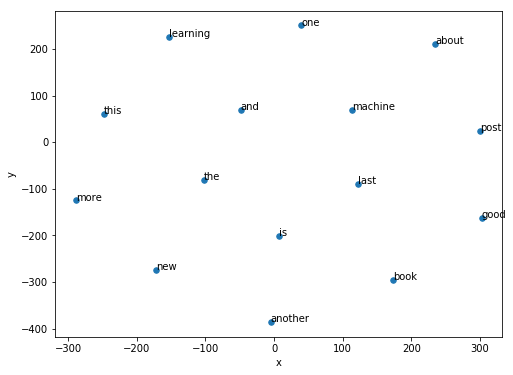

In [143]:
ax = plain_tsne.plot.scatter(x = 'x', y = 'y', figsize = (8, 6), s = 30)
for i, txt in enumerate(plain_tsne.word):
    ax.annotate(txt, (plain_tsne.x.iat[i],plain_tsne.y.iat[i]))

IndexError: index 12 is out of bounds for axis 0 with size 12

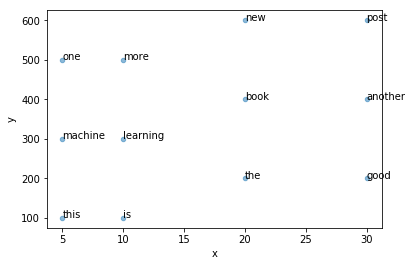

In [140]:
ax = df.plot.scatter(x='x', y='y', alpha=0.5)
for i, txt in enumerate(plain_tsne.word):
    ax.annotate(txt, (df.x.iat[i],df.y.iat[i]))
plt.show()